Specific requirements for the report
Each group will create a final electronic report (max 2000 written words, not including citations) using Jupyter to communicate the question asked, the analysis performed and the conclusion reached.

You must submit 2 files:
the source Jupyter notebook (.ipynb file)
the rendered final document (.html file) 

Each report should include the following sections:

Title

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report clearly state the question you tried to answer with your project identify and describe the dataset that was used to answer the question

Methods & Results:

Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

Your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).

Make sure to cite the source of your data as well.

hint - you can use your proposal as a basis for your final report


## Risk Classification for Firms Utilizing Historical Audit Risk Scores and Discrepancies using KNN Classification

### Group 28 Members: Michael Ly, Avery Ma and Veer Arora

## Introduction

For businesses around the world, there exists a risk of the business working against the best interest of their stakeholders by misrepresenting financial information due to lack of financial controls or auditing procedures. The practice of auditing businesses requires extensive analysis and thorough investigation by accounting and auditing firms. Because there are so many businesses, there are not always enough resources to determine what business would make an appropriate target for an auditing firm to audit.

Our hope is that we can create a classification model that can help auditing firms determine what business would be considered a risk to financial mismanagement and classify them accordingly as targets of future audits.

Given a data set of characteristics of firms of different sectors, historical misstatement scores, and different risk scores would we be able to create a K - Nearest Neighbor classification model that can accurately identify risk firms? And will it be reliable and accurate enough for us to classify whether a firm is a Risk firm or a Non-Risk firm working in the best interest of its stakeholders?

Our data set examines the present and historical risk factors and financial discrepancy scores for the determining the audit risk score and concludes whether the firm is classified under Risk (1) or No Risk (0).

Our data set is drawn from the UCI Machine Learning Repository, with its origins from Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. https://archive.ics.uci.edu/ml/datasets/Audit+Data


We will be using Total, Money Value, Inherent Risk, and Audit Risk as predictors for our KNN classification model that will determine whether an observation is labelled as a Risk firm or a non-Risk firm. 

There are many different variables described in the original audit risk dataset such as analysis scores completed by the original authors that we have decided to remove because they have not been defined. 

The original description of the dataset reports that after an in-depth interview with auditors, important risk factors have been evaluated and probability of existence of these risk factors have been calculated using their present and past records.

We have performed exploratory analysis to determine the best predictors to train our KNN classification model.

Variables we will use as predictors for our classification model based on exploratory analysis:
* Total: Total amount of discrepancy found in auditing reports (PARA_A + PARA_B)
* Money Value: Amount of money involved in misstatements in the past audits
* Inherent Risk: The risk score posed by an error or omission in a financial statement due to a factor other than a failure of internal control
* Audit Risk: The risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated

Labels we will use for classification:
* Risk: Label used to classify whether a firm is considered Risk (1) or No Risk (2)

Variables from data set that will not be used:
* Para A value: Discrepancy found in the planned-expenditure of inspection
* Para B value: Discrepancy found in the unplanned-expenditure of inspection
* Numbers: Historical discrepancy score.
* District Loss: Score based on amount of loss suffered by the district
* History: Average historical loss suffered by firm in the last 10 years.
* Control Risk: The chance of a material misstatement in a company’s financial statements because there aren’t any relevant internal controls to mitigate a particular risk or the internal controls in place malfunctioned.
* Detection Risk: The chance that an auditor will fail to find material misstatements that exist in an entity's financial statements.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
set.seed(2022)
audit_risk_data <- read_csv("https://raw.githubusercontent.com/DicedOnion/dsci-100-2022w1-group-28/main/data/audit_risk.csv")
audit_risk_data <- mutate(audit_risk_data, Risk = as_factor(Risk))

audit_split <- initial_split(audit_risk_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


* We will be working with Risk as our factor so we convert it accordingly before we split our data set.
* We will be training a KNN classification model to predict whether a new observation will be labelled as a risk firm (1) or a non-risk firm (0).
* The data set is first split into training and testing data sets where 75% will be allocated to the training set and the 25% remaining will be used for testing the accuracy of our model.

In [3]:
num_obs <- nrow(audit_training)
audit_training |> 
    group_by(Risk) |> 
    summarize(
        count = n(),
        percentage = n()/num_obs * 100)

Risk,count,percentage
<fct>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


* We then examine the number and percentage between the different levels of our factor within our training data set to see if each class is reasonably represented. We conclude that each class is reasonably represented in our training data set.

In [4]:
audit_training_select <- audit_training |> 
    select(TOTAL, Money_Value, Inherent_Risk, Audit_Risk, Risk) |>
    drop_na()
audit_training_select

TOTAL,Money_Value,Inherent_Risk,Audit_Risk,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4.83,0.94,2.554,0.5108,0
0.08,0.00,1.416,0.2832,0
0.83,2.95,2.156,0.4312,0
⋮,⋮,⋮,⋮,⋮
0.00,0.00,2.20,1.320,1
1.69,0.90,2.93,1.758,1
8.49,0.43,6.58,1.316,1


* We then performed exploratory analysis on the variables in our data set and determined 4 predictors that we will be using to train our training data. We determined that the variables Total Discrepancies, Money Value, Inherent Risk and Audit Risk will be suitable predictors according to the differences in distributions found between the risk and non-risk labels during exploratory analysis.

Warning message:
“Removed 62 rows containing non-finite values (stat_boxplot).”


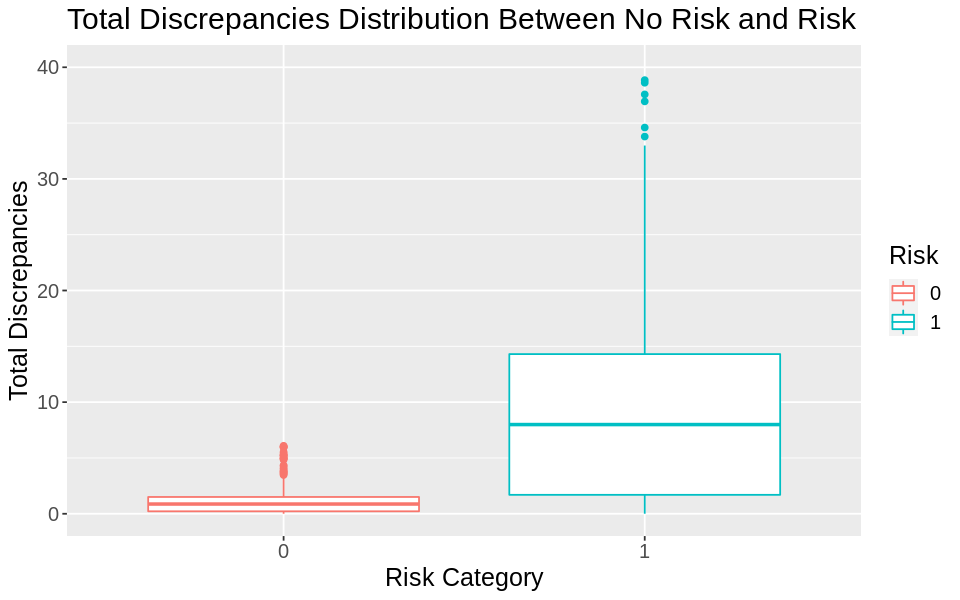

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=TOTAL, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Total Discrepancies") +
  ggtitle("Total Discrepancies Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of total discrepancies (combination of discrepancies found in planned and unplanned reports) between Risk and No Risk. When comparing the total discrepancies across both groups we can see that there is a clear difference between them. There appears to be greater total discrepancies found in the Risk class than that found in the No Risk class as represented by the higher median in the Risk box plot and the non-overlapping interquartile ranges. We can consider using this as a predictor for our model given that it shows this difference.

Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”


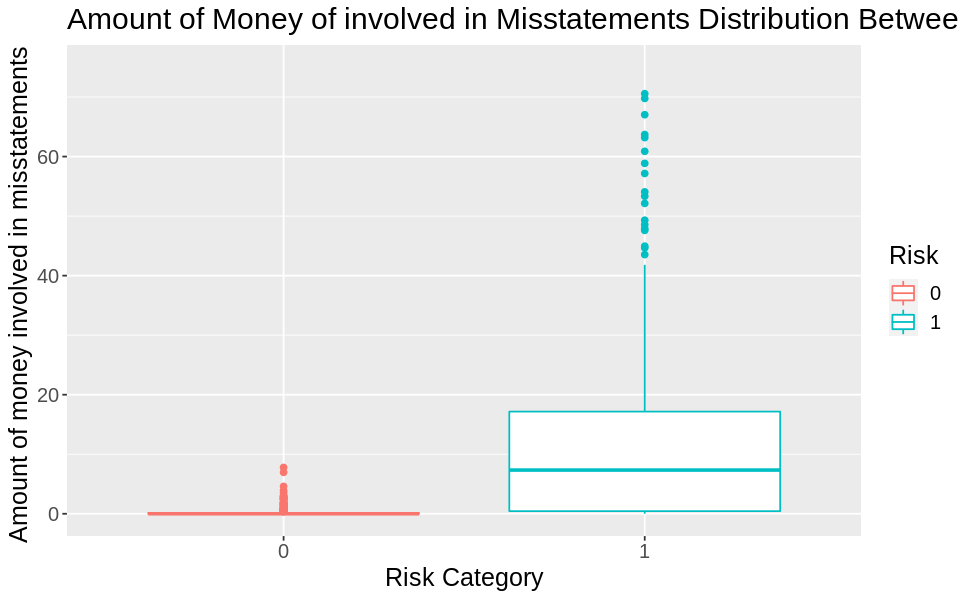

In [18]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Money_Value, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 75)) +
  labs(x = "Risk Category", y = "Amount of money involved in misstatements ") +
  ggtitle("Amount of Money of involved in Misstatements Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* These box plots compare the distribution of money involved in misstatements between Risk and No Risk. It is clear that the Risk group has a higher amount of money involved in misstatements than the No Risk group as represented by the median of both box plots. This is a predictor we can consider using for our model given this difference.

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”


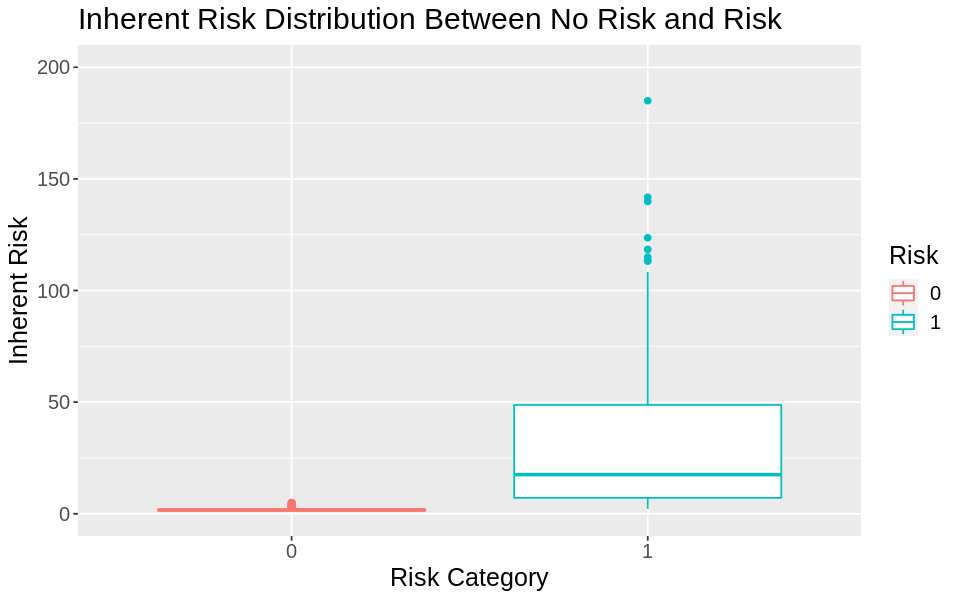

In [7]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Inherent_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 200)) +
  labs(x = "Risk Category", y = "Inherent Risk") +
  ggtitle("Inherent Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* We used a box plot to represent the distribution of inherent risk across both Risk classes. Inherent risk is defined as the risk posed by an error or omission in a financial statement due to a factor other than a failure of internal control. We can see evidently see that firms that are classified as Risk have a far greater inherent risk score than firms with no risk according to our boxplot comparing the distribution of the two classes. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make inherent risk a good reliable predictor for our model.

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


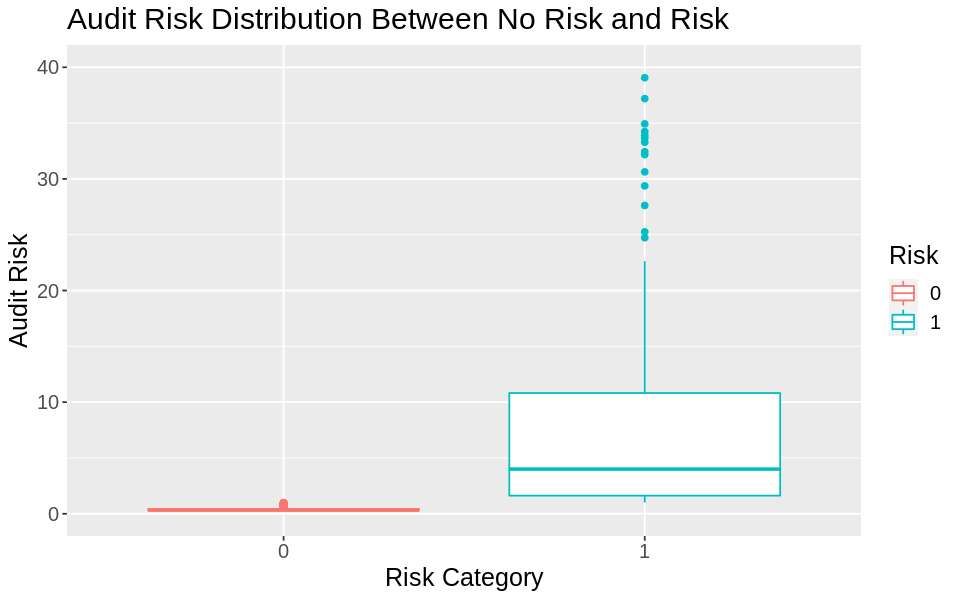

In [8]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(audit_training_select, aes(x = Risk, y=Audit_Risk, color = Risk)) +
  geom_boxplot() +
  ylim(c(0, 40)) +
  labs(x = "Risk Category", y = "Audit Risk") +
  ggtitle("Audit Risk Distribution Between No Risk and Risk") +
  theme(text = element_text(size = 15))

* We use a box plot to represent the distribution of Audit Risk across our two classes. In general, audit risk is defined as the risk that the auditor expresses an inappropriate audit opinion when the financial statements are materially misstated. Looking at the box plot distributions we can see that Risk class firms have a significantly higher distribution of audit risk score than No Risk firms. Both the median and the interquartile ranges do not appear to overlap indicating a difference between the two groups. This would make audit risk a good reliable predictor to utilize in our classification model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



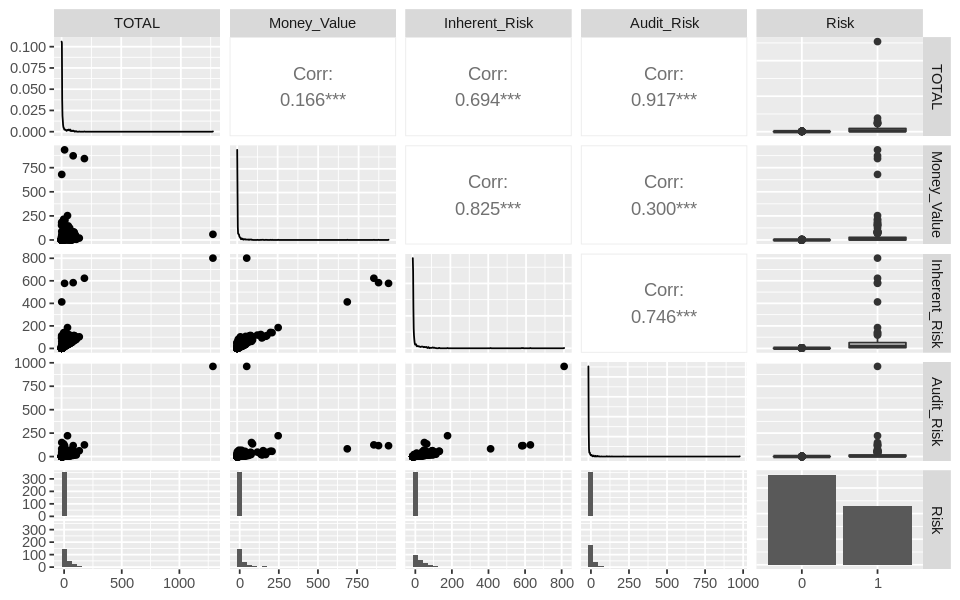

In [9]:
audit_pairs <- audit_training_select |> 
    ggpairs()
audit_pairs

In [13]:
knn_spec <- nearest_neighbor(weight_func ="rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_audit_recipe <- recipe(Risk ~. , data = audit_training_select) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

audit_vfold <- vfold_cv(audit_training_select, v = 5, strata = Risk)


gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

audit_results <- workflow() |>
    add_recipe(knn_audit_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = audit_vfold, grid = gridvals) |>
    collect_metrics()

accuracies <- audit_results |>
    filter(.metric == "accuracy") 

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9965515,5,0.002111917,Preprocessor1_Model01
6,accuracy,binary,0.9879450,5,0.005849906,Preprocessor1_Model02
11,accuracy,binary,0.9879450,5,0.005188088,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.9121385,5,0.009854021,Preprocessor1_Model18
91,accuracy,binary,0.9052715,5,0.013487360,Preprocessor1_Model19
96,accuracy,binary,0.9001285,5,0.015154204,Preprocessor1_Model20


* After determining our four predictors, we then select them to train our model.
* The predictors are then preprocessed through scaling and centering with the recipe function to ensure all predictors have equal influence over the assignment of the label for classification.
* The KNN specifications are first set to tune our classifer using five-fold cross-validation on our training data to find the most optimal $k$ to train our model.
* A workflow function is then applied to the recipe and KNN specifications created
* A data frame is created with a sequence of values of $k$ from 1 to 15 to try.
* This data frame is passed to the tune_grid function within the workflow function
* The collect_metrics function is then applied to generate the the predicted accuracy mean values for each value of $k$

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.01206897
Best kernel: rectangular
Best k: 2

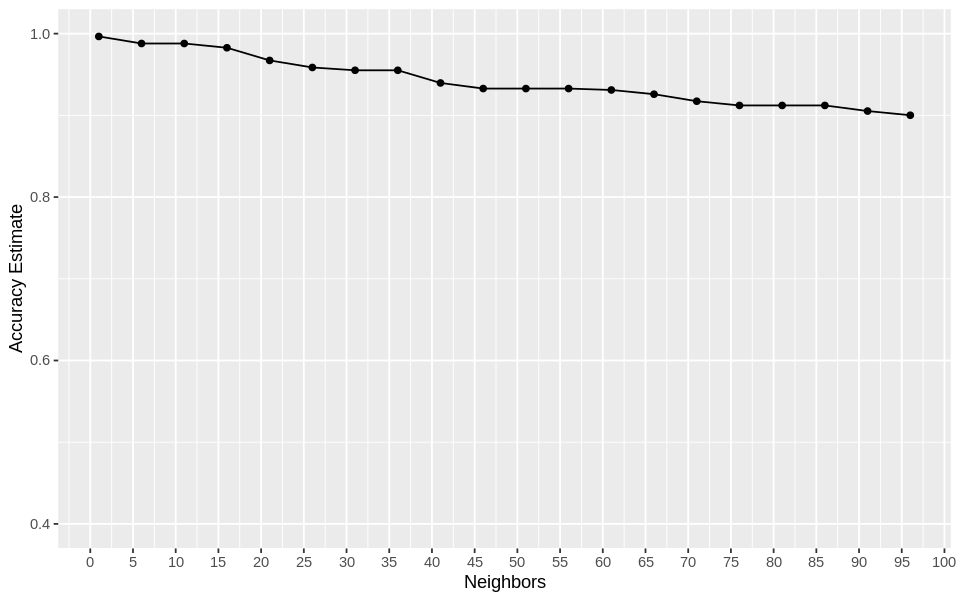

In [16]:
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        scale_x_continuous(breaks = seq(0, 100, by = 5)) +  
        scale_y_continuous(limits = c(0.4, 1.0)) 

cross_val_plot

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_audit_fit <- workflow() |>
    add_recipe(knn_audit_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = audit_training_select)

knn_audit_fit

In [12]:
audit_predictions <- predict(knn_audit_fit, audit_testing) |>
    bind_cols(audit_testing)

audit_metrics <- audit_predictions |> 
    metrics(truth = Risk, estimate = .pred_class)
audit_metrics

audit_conf_mat <- audit_predictions |> 
    conf_mat(truth = Risk, estimate = .pred_class)
audit_conf_mat

New names:
• `Score_B...7` -> `Score_B...8`
• `Score_B...11` -> `Score_B...12`


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9897436
kap,binary,0.9786348


          Truth
Prediction   0   1
         0 116   0
         1   2  77

## Expected Outcomes and Significance
* We hope to find that our classification model is able to reliably predict whether a firm is a Risk firm or a No Risk Firm. If this can be reliably achieved with a high level of accuracy it would allow for audit firms or governments to utilize this model to allow for more productive targeting of specific businesses or firms that have a high risk for financial mismanagement or fraud. 
* Since there can be many other indicators of financial fraud and risk used in business auditing practices, what other predictors can be used to create an even better model for classifying whether a firm should be considered a target for audit? And can it be generalized to different business areas in different parts of the world with different accounting practices?